# Contextual Bandits

Sequential learning environment!

Agent interacts with environment. In beginning there is no data. In each round, an action is taken, and environment gives feedback.

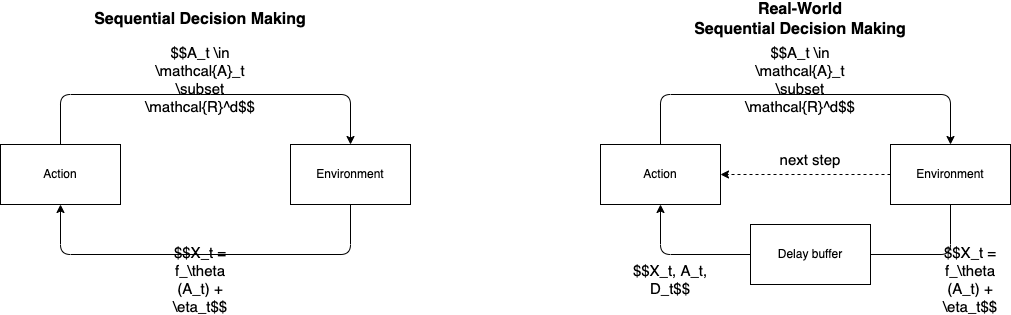

In [2]:
from utils import disp
disp('bandits_intro.drawio.png')

The environment sends noisy feedback. The agent has to learn a policy that is a way to choose the next action given the information that has been observed so far.

In a real-world setting, the environment can be a user. In this case, a delay buffer. After a while, the feedback is sent to agent which will update the policy.

How can we learn an efficient policy for the agent? And, how do we deal with delays?

## Linear Bandits

1. In round $t$, observe action set $\mathcal{A}_t \subset \mathcal{R}^d$

2. The learner chooses $A_t \in \mathcal{A}_t$ and receives $X_t$, satisfying

$$E[X_t | \mathcal{A}_1, A_1, ..., \mathcal{A}_t, A_t] = \bigl<  A_t, \theta_\star \bigr>  \coloneqq f_{\theta \star} (A_t)$$

for some **unknown** $\theta_\star$.

3. Light-tailed noise: $X_t - \bigl< A_t, \theta_\star\bigr>  = \eta_t \sim N(0,1)$

Goal: Keep regret small.

$$R_n = E[ \sum_{t=1}^n  \max_{a \in \mathcal{A}_t} \bigl<  a, \theta_\star \bigr>  - X_t]$$

Regret is the cumulative sum of losses. The loss is the gap between the reward difference between what you would have got if doing it correctly from what you actually did.

The action set should be some subset. It is selected by some adversary.

### Real-world setting

A typical setting is a user, represented by feature vector $u_t$ shows up and we have a finite set of (correlated) actions $(a_1, ..., a_k)$.

Some function $\phi$ joins these vectors pairwise to create a *contextualized action set*:

$\forall i \in [K]$, 

$$\phi(u_t, a_i) = a_{t,i} \in \mathcal{R}^d $$
$$\mathcal{A}_t = \{ a_{t,1}, ..., a_{t,K}\}$$

No assumption is to be made on the joining function $\phi$ as the bandit may take over the decision step from that contexualized action set.

So, it is equivalent to $\mathcal{A}_t \sim \Pi (\mathcal{R}^d)$ some arbitrary distribution, or $\mathcal{A}_1, ..., \mathcal{A}_n$ fixed arbitrarily by the environment.

We want an algorithm which is robust to any choice (even sampled from any unknown distribution).

### Toolbox of the optimist

To minimize the regret...

Say, reward in round $t$ is $X_t$, action in round $t$ is $A_t \in \mathcal{R}^d$:

$$X_t = \bigl< A_t, \theta_\star \bigr> + \eta_t$$

We want to estimate $\theta_\star$: regularized leat-squares estimator:

$$\hat{\theta}_t = V_t^{-1} \sum_{s=1}^t A_s X_s$$

$$V_0 = \lambda I$$

$$V_t = V_0 + \sum_{s=1}^t A_s A_s^\intercal$$

Choice of confidence regions (ellipsoids) $\mathcal{C}_t$:

$$\mathcal{C}_t \dot{=} \biggl\{ \theta \in \mathcal{R}^d : || \theta - \hat{\theta}_{t-1} ||_{V_{t-1}}^2 \leq \beta_t \biggr\}$$

where, for $A$ positive definite, $||x||_{A}^2 = x^\intercal A x$.

Immediately, we can see that $\beta_t$ is a very important hyperparameter.

### LinUCB

"Choose the best action in the best environment amongst the plausible ones."

Choose $\mathcal{C}_t$ with suitable $(\beta_t)_t$ and let 

$$A_t = \argmax_{a \in \mathcal{A}} \max_{\theta \in \mathcal{C}_t} \bigl< a, \theta \bigr>$$


Or, more concretely, for each action $a \in \mathcal{A}$, compute the "optimistic index"

$$U_t(a) = \max_{\theta \in \mathcal{C}_t} \bigl< a, \theta \bigr>$$

Maximising a linear function over a convex closed set, the solution is explicit:

$$A_t = \argmax_{a} U_t(a) = \argmax_{a} \bigl< a, \hat{\theta}_t \bigr> + \sqrt{\beta_t} ||a||_{V_{t-1}^{-1}}$$


At round $t$, I have an estimator (red dot) $\hat{\theta}_t$ which is encompassed by a confidence ellipsoid (here it is round because we have Tikhonov regularization, which uses $\lambda I$) and at round $t$ for each green dot (i.e. actions, or arms), we compute an index and choose a vector (red circle around green arm dot) which is $a_{1,t} = A_t$ which has the best scalar product with $\theta$.

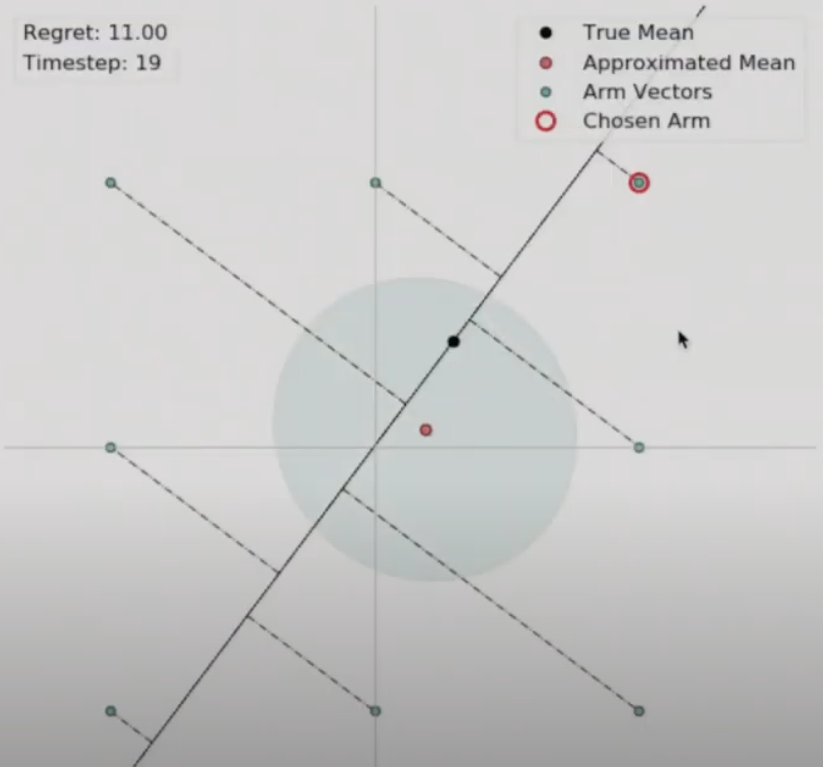

In [3]:
disp('bandit_uncertainty_principle.png')

In beginning, we have confidence elliposid which is round. But then we pull the action in direction of the action that gives a lot of reward. But, sometimes this chooses an action which is bad and it increases the uncertainty which makes it rounder. This is how we regulate exploration vs exploitation.

Exploitation pulls in direction which makes it ovular and exploration is when we reshape the ellipsoid of competence. 

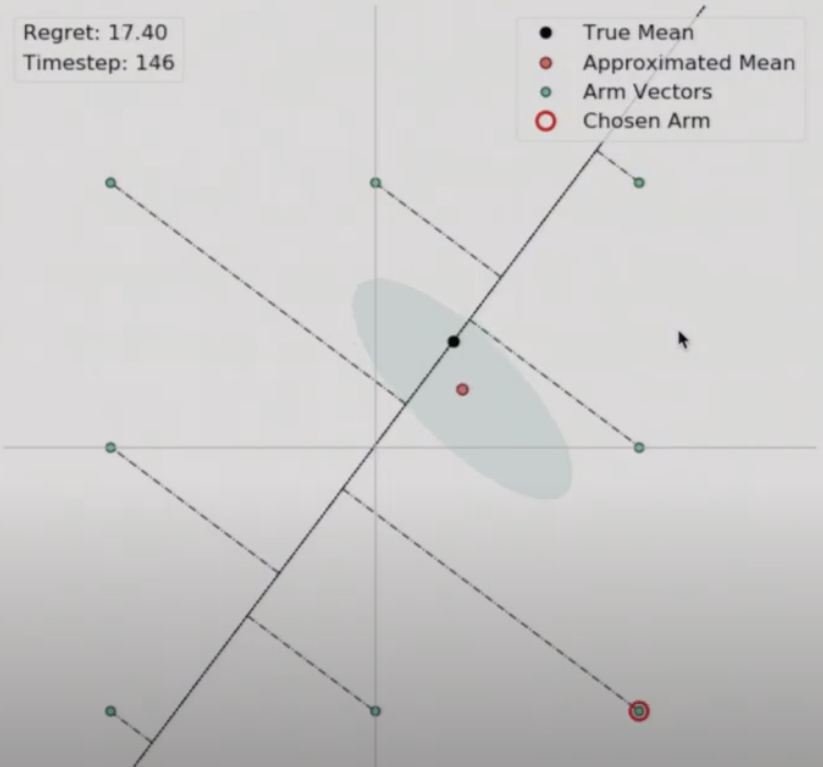

In [4]:
disp('bandits_uncertainty_principle_laterepoch.png')

### Regret bound

So what is the regret of linearity?

We first make a few assumptions that the rewards and parameters are bounded, namely:

1. Bounded scalar mean reward: $|\bigl< a, \theta_\star \bigr>| \leq 1$ for any $a \in \cup_t A_t$

2. Bounded actions: for any $a \in \cup_t \mathcal{A}_t$, $||a||_2 \leq L$

3. Honest confidence intervals: There exists a $\delta \in (0, 1)$ such that with probability $1 - \delta$ for all $t \in [n]$, $\theta_\star \in \mathcal{C}_t$ for some choice of $(\beta_t)_{t \leq n}$

**Theorem (LinUCB Regret)**

Let the conditions listed above hold. Then with $1 - \delta$ the regret of LinUCB satisfies

$$\hat{R}_n \leq \sqrt{8dn\beta_n \log \biggl( \frac{d \lambda + n L^2}{d \lambda} \biggr)}$$

**Proof**

Jensen's inequality shows that

$$\hat{R}_n = \sum_{t=1}^n \bigl< A_t^\star - A_t, \theta \bigr> \coloneqq \sum_{t=1}^n r_t \leq \sqrt{n \sum_{t=1}^n r_t^2 }$$

where $A_t^\star \dot{=} \argmax_{a \in \mathcal{A}_t} \bigl< a, \theta_\star \bigr>$ is the optimal action.

Let $\tilde{\theta}_t$ be the vector that realizes the maximum over the ellipsoid:

$\theta_t \in \mathcal{C}_t$ s.t. $\bigl< A_t, \tilde{\theta}_t \bigr> = U_t(A_t)$

From the definition of LinUCB,

$$\bigl< A_t^\star, \theta_\star \bigr> \leq U_t(A_t^\star) \leq U_t(A_t) = \bigl< A_t, \tilde{\theta}_t \bigr>$$

Then, (by Cauchy-Schwartz with VT-norm)

$$r_t \leq \bigl< A_t, \tilde{\theta}_t - \theta_\star \bigr> \leq ||A_t||_{V_{t-1}^{-1}} ||\tilde{\theta}_t - \theta_\star||_{V_{t-1}} \leq 2 ||A_t||_{V_{t-1}^{-1}} \sqrt{\beta_t}$$

So now we know the bound of $r_t$ and can use it in Jensen's inequality.

### Elliptical Potential Lemma

So we now have a new upper bound, 

$$\hat{R}_n = \sum_{i=1}^n r_t \leq \sqrt{n \sum_{t=1}^n r_t^2} \leq 2 \sqrt{n \beta_n \sum_{t=1}^n \bigl(1 \wedge ||A_t||^2_{V_{t-1}^{-1}} \bigr) }$$

where $\bigl(1 \wedge ||A_t||^2_{V_{t-1}^{-1}} \bigr)$ is the norm squared of your actions.

**Lemma (Abbasi-Yadkori et al. (2001))**

Let $x_1, ..., x_n \in \mathcal{R}^d$, $V_t = V_0 + \sum_{s=1}^t x_s x_s^\intercal$, $t \in [n]$ and $L \geq \max_t ||x_t||_2$. Then,

$$\sum_{t=1}^n \bigl( 1 \wedge ||x_t||^2_{V_{t-1}^{-1}} \bigr) \leq 2 \log \bigl( \frac{\det V_n}{\det V_0} \bigr) \leq d \log \bigl( \frac{\hbox{trace}(V_0) + nL^2}{d \det^{1/d}(V_0)} \bigr)$$

See Chapter 20 of Bandit Algorithms located here: https://tor-lattimore.com/downloads/book/book.pdf

### Summary of Theorem (LinUCB Regret)

Let the conditions listed above hold. Then with $1 - \delta$ the regret of LinUCB satisfies

$$\hat{R}_n \leq \sqrt{8dn\beta_n \log \biggl( \frac{d \lambda + n L^2}{d \lambda} \biggr)}$$

Linear bandits are an elegant model of the exploration-exploitation dilemma when actions are correlated. The main ingredients of the regret analysis are

* bounding the instantaneous regret using the definition of optimism

* a maximal concentration inequality holding for a randomized, sequential design

* the elliptical potential lemma

## Real-World Setting: Delayed Feedback

If you have a delay, the learner is going to stop waiting. For instance, after $m$ timestamps, it will start deleting data (inside the delay buffer).

Modified settings: at round $t \geq 1$, 

* receive contextualized action set $\mathcal{A}_t = \{ a_1, ..., a_k \}$ and choose action $A_t \in \mathcal{A}_t$,

* two random variables are generated but not observed: $X_t \sim \mathcal{B} (\theta^\intercal A_t)$ and $D_t \sim \mathcal{D}(\tau)$

* at $t + D_t$ the reward $X_t$ of action $A_t$ is disclosed ...

* ...unless $D_t > m$: if the delay is too long, the reward is discarded.

New parameter: $0 < m < T$ is the cut-off time of the system. If the delay is longer, the reward is never received. The delay distribution $\mathcal{D}(\tau)$ characterizes the proportion of converting actions $\tau_m = p(D_t \leq m)$. So this denotes the amount of data which is sent back to the agent.

We now have covariance metric $V_t$ and slightly changed $b_t$ vector which is the sum of the actions weighted by $X_t$ times an indicator that it was part of those data actually in delay.

$$V_t = \sum_{s=1}^{t-1} A_s A_s^\intercal$$

$$\tilde{b}_t = \sum_{s=1}^{t-1} A_s X_s \mathcal{1} \bigl\{ D_s \leq m \bigr\}$$

where $\tilde{b}_t$ contains additional non-identically distributed samples:

$$\tilde{b}_t = \sum_{s=1}^{t-m} A_s X_s \mathcal{1} \bigl\{ D_s \leq m \bigr\} + \sum_{s=t-m+1}^{t-1} A_s X_s \mathcal{1} \bigl\{ D_s \leq t-s \bigr\}$$

It is split into two parts: 1) old actions made a long time ago, 2) actions made in last delay portion.

This establishes a new estimator

$$\hat{\theta}_t^b = V_t^{-1} \tilde{b}_t$$

a "conditionally biased" least squares estimator which includes every recieved feedback. It is biased because the last set of observations are still awaiting reward somewhere in the buffer -- these are not all iid because the probabiliyt of the delay being smaller than t-s is not the same as for all the actions. This hurts the estimator. 

Baseline: use previous estimator but discord last $m$ steps

$$\hat{\theta}_t^{disc} = V_{t-m}^{-1} b_{t-m}$$

with $E[\hat{\theta}_t^{disc} | \mathcal{F}_t] \approx \tau_m \theta$

We remark that

$$\begin{align*}
\hat{\theta}_t^b &= \hat{\theta}_t^b - \hat{\theta}_{t+m}^{disc} + \hat{\theta}_{t+m}^{disc} - \tau_m \theta\\ 
\end{align*}$$

where $\hat{\theta}_t^b - \hat{\theta}_{t+m}^{disc}$ contians the finite biase and $\hat{\theta}_{t+m}^{disc} - \tau_m \theta$ is the same as before.

For the new $\mathcal{C}_t$, we have new optimistic indices

$$A_t = \argmax_{a \in \mathcal{A}} \max_{\theta \in \mathcal{C}_t} \bigl< a, \theta \bigr>$$

But now, the solution has an extra (vanishing) bias term

$$A_t = \argmax_a \bigl< a, \hat{\theta}_t \bigr> + \sqrt{\beta_t} ||a||_{V_{t-1}^{-1}} + m ||a||_{V_{t-1}^{-2}}$$

**D-LinUCB** : Easy, straightforward, harmless modification of LinUCB, with regret guarantees in the delayed feedback setting

**Regret bound (Theorem: D-LinUCFB Regret)**

Under the same conditions as before, with $V_0 = \lambda I$, with probability $1 - \delta$ the regret of D-LinUCB satisfies

$$\hat{R}_n \leq \tau_m^{-1} \sqrt{8 d n \beta_n \log \biggl(  \frac{\hbox{trace}(V_0) + nL^2}{d \det^{1/d}(V_0)} \biggr)} + \frac{dm}{(\lambda-1)\tau_m^{-1}} \log \bigl( 1 + \frac{n}{d(\lambda-1)} \bigr)$$

So, we have an extra term. Note: There is a dependency on $\tau_m$ here.

## Conclusion

* Linear bandits are a powerful and well-understood way of solving the exploration-exploitation trade-off in a metric space

* The techniques have been extended to generalized linear models by Filippi et al

* and to kernel regression Valko et al

* Yet, including constraints and external sources of noise in real-world applications is challenging

* Sometimes when make action, it modifies environment and then following this environment change, it gets reward that credits to first action. In general RL setting, you take actions but don't get reward immediately. You change position in space and rewards come later (in delayed way). In this case, we have to go out of the bandit assumption and open markov decision processes box (e.g. UCRL abd KL-UCRL Auer et al., Filippi et al.)

